In [2]:
import pymysql 
from sqlalchemy import create_engine 
import pandas as pd 
import getpass # to get the password without it being visible CONNECTION TO SQL
password= getpass.getpass()

········


In [3]:
connection_string = "mysql+pymysql://root:" + password + '@localhost/bank'
engine = create_engine(connection_string)

query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id;
"""

In [4]:
data = pd.read_sql_query(query, engine)

In [5]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


In [6]:
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

In [7]:
len(data)

868019

In [81]:
data = data[~data['duration'].isna()]  #Clean all the Null

In [9]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10745 entries, 2037 to 867430
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       10745 non-null  object 
 1   operation  10745 non-null  object 
 2   t_amount   10745 non-null  float64
 3   balance    10745 non-null  float64
 4   k_symbol   10745 non-null  object 
 5   l_amount   10745 non-null  float64
 6   duration   10745 non-null  object 
 7   payments   10745 non-null  float64
 8   status     10745 non-null  object 
dtypes: float64(4), object(5)
memory usage: 839.5+ KB


In [10]:
#turning duration into categorical, because it comes in values of whole years (1,2,3,4,5)

data['duration'] = data['duration'].astype('object')

# a. Cleaning categoricals

In [34]:
data['operation'].value_counts()

prevod    10156
vyber       589
Name: operation, dtype: int64

In [35]:
#Group by similar name avoiding blank space 

def clean_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else: 
        return 'unknown'

In [36]:
data['operation'] = data['operation'].apply(clean_operation)  #You apply the above function 

In [37]:
data['k_symbol'].value_counts().index

Index(['UVER', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [38]:
#Clean the symbol

def clean_ksymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [39]:
data ['k_symbol'] = data['k_symbol'].apply(clean_ksymbol)

In [43]:
data['k_symbol'].value_counts()

UVER           7744
POJISTNE       2412
SANKC. UROK     589
Name: k_symbol, dtype: int64

In [41]:
#Filter data so that  k_symbol is cleaned of POJISTNE, SANKC. UROK, UVER

#data['k_symbol'].isin(['POJISTNE','SANKC. UROK', 'UVER'])

data = data[data['k_symbol'].isin(['POJISTNE','SANKC. UROK', 'UVER'])] #final recall dataframe and confirm df

In [42]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
2037,VYDAJ,prevod,956.0,70740.2,POJISTNE,165960.0,36.0,4610.0,A
2326,VYDAJ,prevod,1017.0,88173.8,POJISTNE,174744.0,24.0,7281.0,B
3656,VYDAJ,prevod,1017.0,74725.5,POJISTNE,174744.0,24.0,7281.0,B
4901,VYDAJ,prevod,956.0,26456.9,POJISTNE,165960.0,36.0,4610.0,A
5053,VYDAJ,prevod,66.0,47679.8,POJISTNE,127080.0,60.0,2118.0,A


In [33]:
data['k_symbol'].value_counts()

UVER           7744
POJISTNE       2412
SANKC. UROK     589
Name: k_symbol, dtype: int64

In [47]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else: 
        return x

In [48]:
data['type'] = data['type'].apply(clean_type)

In [49]:
data['type'].value_counts()

VYDAJ    10745
Name: type, dtype: int64

# b. Check correlations for numerical columns

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [51]:
data.corr()

,t_amount,balance,l_amount,payments
t_amount,1.000000,0.150726,0.468135,0.592942
balance,0.150726,1.000000,0.009273,0.031490
l_amount,0.468135,0.009273,1.000000,0.737717
payments,0.592942,0.031490,0.737717,1.000000


In [52]:
corr_matrix = data.corr()

In [53]:
type(corr_matrix)

pandas.core.frame.DataFrame

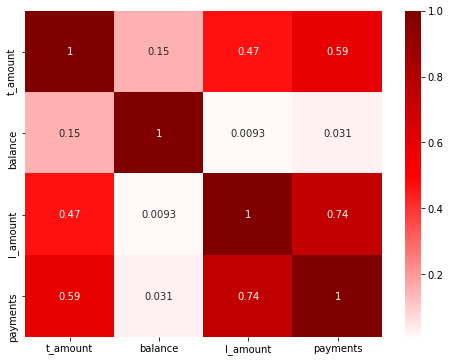

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr_matrix,
            cmap = 'seismic',
           center = 0,
           annot = True,
           );

*Note: some high correlation between my features come back after first model validation and maybe drop highly correlated features 

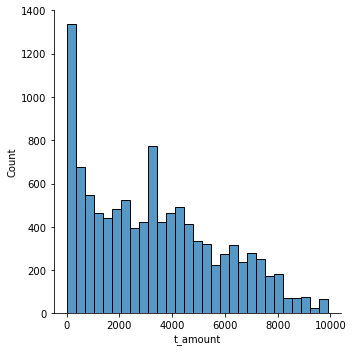

In [55]:
sns.displot(data['t_amount'])

In [56]:
data['t_amount'].describe()

count    10745.000000
mean      3305.852825
std       2466.900152
min          0.000000
25%       1177.000000
50%       3132.000000
75%       5011.200000
max       9910.000000
Name: t_amount, dtype: float64

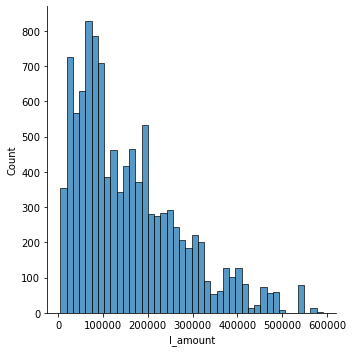

In [60]:
sns.displot(data['l_amount'])

In [61]:
data['l_amount'].describe()

count     10745.000000
mean     157731.369381
std      115953.404571
min        4980.000000
25%       68340.000000
50%      128988.000000
75%      224604.000000
max      590820.000000
Name: l_amount, dtype: float64

# Pre Processing

In [67]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)

In [68]:
X.head()

,t_amount,balance,l_amount,payments
2037,956.0,70740.2,165960.0,4610.0
2326,1017.0,88173.8,174744.0,7281.0
3656,1017.0,74725.5,174744.0,7281.0
4901,956.0,26456.9,165960.0,4610.0
5053,66.0,47679.8,127080.0,2118.0


In [69]:
transformer = Normalizer()
transformer.fit(X)
x_normalized = transformer.transform(X)

In [70]:
x = pd.DataFrame(x_normalized, columns=x.columns)

In [71]:
y = data ['status']

In [72]:
len(x), len(y), len(data)

(10745, 10745, 10745)

In [73]:
data['duration'].value_counts()

60.0    2797
48.0    2299
36.0    2106
24.0    2007
12.0    1536
Name: duration, dtype: int64

In [74]:
x

,t_amount,balance,l_amount,payments
0,0.005297,0.391980,0.919604,0.025545
1,0.005192,0.450170,0.892154,0.037173
2,0.005347,0.392893,0.918772,0.038282
3,0.005686,0.157368,0.987143,0.027421
4,0.000486,0.351241,0.936155,0.015603
...,...,...,...,...
10740,0.000040,0.051057,0.997830,0.041576
10741,0.000050,0.004776,0.999122,0.041630
10742,0.000067,-0.005245,0.999847,0.016664
10743,0.000041,0.695114,0.718277,0.029928


In [76]:
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
2037,VYDAJ,prevod,956.0,70740.2,POJISTNE,165960.0,36.0,4610.0,A
2326,VYDAJ,prevod,1017.0,88173.8,POJISTNE,174744.0,24.0,7281.0,B
3656,VYDAJ,prevod,1017.0,74725.5,POJISTNE,174744.0,24.0,7281.0,B
4901,VYDAJ,prevod,956.0,26456.9,POJISTNE,165960.0,36.0,4610.0,A
5053,VYDAJ,prevod,66.0,47679.8,POJISTNE,127080.0,60.0,2118.0,A
...,...,...,...,...,...,...,...,...,...
865697,VYDAJ,vyber,5.5,7056.3,SANKC. UROK,137904.0,24.0,5746.0,B
866091,VYDAJ,vyber,9.6,920.5,SANKC. UROK,192552.0,24.0,8023.0,B
866915,VYDAJ,vyber,36.3,-2838.9,SANKC. UROK,541200.0,60.0,9020.0,D
867278,VYDAJ,vyber,3.5,59667.7,SANKC. UROK,61656.0,24.0,2569.0,B


### Dummy 

In [83]:
cat = data.select_dtypes(include = np.object)
cat

<ipython-input-83-a2417216adda>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data.select_dtypes(include = np.object)


,type,operation,k_symbol,duration,status
2037,VYDAJ,prevod,POJISTNE,36.0,A
2326,VYDAJ,prevod,POJISTNE,24.0,B
3656,VYDAJ,prevod,POJISTNE,24.0,B
4901,VYDAJ,prevod,POJISTNE,36.0,A
5053,VYDAJ,prevod,POJISTNE,60.0,A
...,...,...,...,...,...
865697,VYDAJ,vyber,SANKC. UROK,24.0,B
866091,VYDAJ,vyber,SANKC. UROK,24.0,B
866915,VYDAJ,vyber,SANKC. UROK,60.0,D
867278,VYDAJ,vyber,SANKC. UROK,24.0,B


In [84]:
cat = cat.drop(['status'], axis=1)

In [85]:
cat.head()

,type,operation,k_symbol,duration
2037,VYDAJ,prevod,POJISTNE,36.0
2326,VYDAJ,prevod,POJISTNE,24.0
3656,VYDAJ,prevod,POJISTNE,24.0
4901,VYDAJ,prevod,POJISTNE,36.0
5053,VYDAJ,prevod,POJISTNE,60.0


In [86]:
categorical=pd.get_dummies(cat, 
               drop_first=True,
               columns=['type', 'operation', 'k_symbol', 'duration'])

In [87]:
categorical.head()

,operation_vyber,k_symbol_SANKC. UROK,k_symbol_UVER,duration_24.0,duration_36.0,duration_48.0,duration_60.0
2037,0,0,0,0,1,0,0
2326,0,0,0,1,0,0,0
3656,0,0,0,1,0,0,0
4901,0,0,0,0,1,0,0
5053,0,0,0,0,0,0,1


# Modelling

In [88]:
x.head()

,t_amount,balance,l_amount,payments
0,0.005297,0.391980,0.919604,0.025545
1,0.005192,0.450170,0.892154,0.037173
2,0.005347,0.392893,0.918772,0.038282
3,0.005686,0.157368,0.987143,0.027421
4,0.000486,0.351241,0.936155,0.015603


In [89]:
categorical.head()

,operation_vyber,k_symbol_SANKC. UROK,k_symbol_UVER,duration_24.0,duration_36.0,duration_48.0,duration_60.0
2037,0,0,0,0,1,0,0
2326,0,0,0,1,0,0,0
3656,0,0,0,1,0,0,0
4901,0,0,0,0,1,0,0
5053,0,0,0,0,0,0,1


In [ ]:
y = data['status']

In [91]:
len(x), len(y), len(data)

(10745, 10745, 10745)

In [92]:
x = np.concatenate